In [149]:
# import numpy as np
# a = np.zeros((156816, 36, 53806), dtype='uint8')
# a.nbytes

mask = np.zeros(edges.shape)
mask = np.zeros(edges.shape,dtype='uint8')

NameError: name 'edges' is not defined

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [242]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None  # default='warn'

# magic word for producing visualizations in notebook
%matplotlib inline

In [78]:
# show maximum number of columns
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [79]:
# load in the data
azdias_read = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=',')#.drop(['Unnamed: 0'])
customers_read = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=',')#.drop(['Unnamed: 0'])

In [80]:
# drop index column
azdias = azdias_read.drop(['Unnamed: 0'], axis = 1)
customers = customers_read.drop(['Unnamed: 0'], axis = 1)

Load description of features to test if all features satisfies the requirements provided in the excel sheet. 

In [81]:
attributes = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header = 0, names = ['unknown', 'Attribute', 'Description', 'Value', 'meaning']).drop(['unknown', 'meaning'], axis = 1).fillna(method='ffill')
attributes = attributes.drop(attributes.index[0])

#### Data check

##### Combine attributes with all possible values.

In [82]:
# Excluded attributes where value can get many different numerical value. 
attributes_values = attributes[attributes['Value'] != "…"].groupby('Attribute')['Value'].apply(list)
attributes_values_df = pd.DataFrame({'attribute':attributes_values.index, 'attribute_values': attributes_values.values})

Aggregate dataframes values and save possible values to the new dataframe

In [83]:
def collect_column_values(df):
    """Returns dataframe with its columns and possible values

    Parameters:
        df (dataframe): Original dataframe;

    Returns:
        dataframe: column and values
    """
    temp_list = []
    for col in df.columns:
        val = list(df.loc[:, col].unique())
        temp_list.append((col, val))
    result = pd.DataFrame(temp_list, columns = ['column', 'values'])
    return result

In [84]:
customers_values = collect_column_values(customers)

In [85]:
attr_comparison_df = pd.merge(customers_values, attributes_values_df,  how='left', left_on=['column'], right_on = ['attribute'])

Only 265 out of 370 columns in the customers dataframe have columns which descriptions we can find in the attributes excel sheet. 

In [86]:
attr_comparison_df[attr_comparison_df['attribute_values'].notnull()].count()

column              265
values              265
attribute           265
attribute_values    265
dtype: int64

In [95]:
# find mixed type columns and unify type

In [100]:
def find_mixed_type_columns(df):
    """Returns list with column names which have multiple types.

    Parameters:
        df (dataframe): Original dataframe
        
    Returns:
        list: with mixed data type
    """
    cols = []
    for col in df.columns:
        mixed = (df[[col]].applymap(type) != df[[col]].iloc[0].apply(type)).any(axis = 1)
        if len(df[mixed]) > 0:
            cols.append(col)
    return cols

In [174]:
find_mixed_type_columns(azdias)

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

In [175]:
customers.CAMEO_DEU_2015.value_counts()

2D    11208
6B     9634
4C     9053
3D     8085
4A     7507
3C     6628
1D     5880
2C     5076
5D     4546
8A     4252
1A     4198
7A     4109
8B     3790
2A     3715
2B     3485
7B     3421
1E     3337
6E     3086
6C     2832
8C     2801
8D     2206
1C     2206
4D     2124
4B     2093
5A     1969
9D     1957
3A     1904
3B     1773
5B     1696
5C     1574
9E     1508
4E     1287
6D     1235
7C     1194
6F     1168
1B     1157
5F     1059
7E     1034
9A     1023
9C      987
9B      917
5E      822
7D      800
6A      762
XX      126
Name: CAMEO_DEU_2015, dtype: int64

In [176]:
customers.CAMEO_DEUG_2015.value_counts()

2      17574
4      16458
6      14008
3      13585
1      12498
8       9716
5       8624
7       7878
2.0     5910
4.0     5606
3.0     4805
9       4731
6.0     4709
1.0     4280
8.0     3333
5.0     3042
7.0     2680
9.0     1661
X        126
Name: CAMEO_DEUG_2015, dtype: int64

In [177]:
customers.CAMEO_INTL_2015.value_counts()

14      14708
24      13301
41       8461
43       7158
25       6900
15       6845
51       5987
13       5728
22       5566
14.0     4939
24.0     4504
23       4276
34       3945
45       3936
54       3537
41.0     2859
55       2794
12       2791
43.0     2476
25.0     2472
15.0     2372
44       2144
51.0     2126
31       2050
13.0     1955
22.0     1941
35       1741
23.0     1494
34.0     1423
45.0     1352
54.0     1258
32       1256
33       1178
12.0      924
55.0      920
52        770
44.0      688
31.0      681
35.0      553
32.0      440
33.0      396
52.0      253
XX        126
Name: CAMEO_INTL_2015, dtype: int64

In [178]:
customers.D19_LETZTER_KAUF_BRANCHE.value_counts()

D19_UNBEKANNT             31910
D19_SONSTIGE              14540
D19_VERSICHERUNGEN        10534
D19_BUCH_CD               10038
D19_VOLLSORTIMENT          8647
D19_HAUS_DEKO              8129
D19_SCHUHE                 6317
D19_BEKLEIDUNG_GEH         5975
D19_DROGERIEARTIKEL        5528
D19_ENERGIE                4454
D19_BEKLEIDUNG_REST        4096
D19_VERSAND_REST           3619
D19_BANKEN_DIREKT          3466
D19_LEBENSMITTEL           3053
D19_TELKO_REST             2303
D19_NAHRUNGSERGAENZUNG     2253
D19_TELKO_MOBILE           2131
D19_TECHNIK                1836
D19_BANKEN_GROSS           1684
D19_FREIZEIT               1672
D19_SAMMELARTIKEL          1610
D19_RATGEBER               1519
D19_KINDERARTIKEL          1439
D19_WEIN_FEINKOST          1424
D19_BANKEN_REST            1233
D19_BIO_OEKO                808
D19_REISEN                  666
D19_DIGIT_SERV              653
D19_GARTEN                  568
D19_HANDWERK                532
D19_BILDUNG                 357
D19_TIER

In [179]:
customers.EINGEFUEGT_AM.value_counts()


1992-02-10 00:00:00    64744
1992-02-12 00:00:00    43686
2003-11-18 00:00:00     1066
2005-12-16 00:00:00      808
1995-02-07 00:00:00      569
                       ...  
2004-09-05 00:00:00        1
2003-03-03 00:00:00        1
2003-07-15 00:00:00        1
2006-12-13 00:00:00        1
2003-07-02 00:00:00        1
Name: EINGEFUEGT_AM, Length: 3034, dtype: int64

In [ ]:
CAMEO_DEUG_2015 X -> NAN
CAMEO_INTL_2015 XX -> NAN

In [104]:
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [105]:
customers.dtypes.value_counts()

float64    267
int64       94
object       8
dtype: int64

The majority of columns are float data type, only 6 columns in both dataframes are strings.

The goal is to find out if there are any additional values in customers dataframe which can not be found in the attributes descriptions.

In [87]:
attribute_differences = []

In [89]:
for index, row in attr_comparison_df.iterrows():
    attr_comparison_df = attr_comparison_df[attr_comparison_df['attribute_values'].notnull()]
    attribute_differences.append((attr_comparison_df['column'][index], set(attr_comparison_df['values'][index]) - set(attr_comparison_df['attribute_values'][index])))

In [91]:
attribute_differences_df = pd.DataFrame(attribute_differences, columns = ['column', 'values'])
attribute_differences_df['length'] = attribute_differences_df['values'].str.len()
attribute_differences_df.sort_values('length', ascending = False, inplace = True)

In [94]:
attribute_differences_df

,column,values,length
4,CAMEO_DEUG_2015,"{nan, 7, 2, 4, X, 9, 3, 6, 8, 5, 1}",11
74,KBA05_KRSHERST3,"{nan, 9.0}",2
68,KBA05_HERST4,"{nan, 9.0}",2
79,KBA05_KW1,"{nan, 9.0}",2
78,KBA05_KRSZUL,"{nan, 9.0}",2
...,...,...,...
36,FINANZ_SPARER,{},0
37,FINANZ_UNAUFFAELLIGER,{},0
38,FINANZ_VORSORGER,{},0
39,FINANZTYP,{},0


In [103]:
# Comparison of data types by dataframe

In [23]:
# I filter columns where difference between original value and documentation differ at least one value. 
attribute_differences_df[attribute_differences_df['length'] > 1].head(60)

,column,values,length
4,CAMEO_DEUG_2015,"{nan, 1, 2, 6, 9, X, 7, 3, 4, 8, 5}",11
74,KBA05_KRSHERST3,"{nan, 9.0}",2
68,KBA05_HERST4,"{nan, 9.0}",2
79,KBA05_KW1,"{nan, 9.0}",2
78,KBA05_KRSZUL,"{nan, 9.0}",2
77,KBA05_KRSVAN,"{nan, 9.0}",2
76,KBA05_KRSOBER,"{nan, 9.0}",2
75,KBA05_KRSKLEIN,"{nan, 9.0}",2
109,KBA05_ZUL2,"{nan, 9.0}",2
73,KBA05_KRSHERST2,"{nan, 9.0}",2


columns which naming starts with KBA... has multiple possible values for unknown value. As a result, in this list there are a lot of columns with these values. Only the KBA05_MODTEMP column has to be filled with nan values whre value = 6 as it is not known value in attributes file. 

In [24]:
customers['KBA05_MODTEMP'] = customers['KBA05_MODTEMP'].replace(6, None)
customers['CAMEO_DEU_2015'] = customers['CAMEO_DEU_2015'].replace("XX", None)
customers['LP_LEBENSPHASE_GROB'] = customers['LP_LEBENSPHASE_GROB'].replace(0, None)

In [25]:
azdias

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,K

In [185]:
def replace_values(df):
    """Returns dataframe with modified values because of missing description.

    Parameters:
        df (dataframe): Original dataframe
        
    Returns:
        dataframe: dataframe with set selected columns to None
    """
    df_new = df
    df_new['KBA05_MODTEMP'] = df['KBA05_MODTEMP'].replace(6, None)
    df_new['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace("XX", None)
    df_new['LP_LEBENSPHASE_GROB'] = df['LP_LEBENSPHASE_GROB'].replace(0, None)
    df_new['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace("X", None)
    df_new['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace("XX", None)

    return df_new

In [182]:
customers['CAMEO_DEUG_2015'].value_counts()

2      17574
4      16458
6      14008
3      13585
1      12498
8       9716
5       8624
7       7878
2.0     5910
4.0     5606
3.0     4805
9       4731
6.0     4709
1.0     4280
8.0     3333
5.0     3042
7.0     2680
9.0     1661
X        126
Name: CAMEO_DEUG_2015, dtype: int64

1. Not all columns has descriptios in files:./DIAS Information Levels - Attributes 2017.xlsx, because shape of populiation (azdias df is 367) while in the file 
314.
2. Calculate the percent of null information in the df. There are some columns where missing values > 90%. These columns should be excluded as to not get confusion. 

In [28]:
len(azdias) - azdias.count()

Unnamed: 0                  0
LNR                         0
AGER_TYP                    0
AKT_DAT_KL              73499
ALTER_HH                73499
                        ...  
WOHNDAUER_2008          73499
WOHNLAGE                93148
ZABEOTYP                    0
ANREDE_KZ                   0
ALTERSKATEGORIE_GROB        0
Length: 367, dtype: int64

In [29]:
(azdias.isnull().sum()/len(azdias)*100).sort_values(ascending = False)

ALTER_KIND4               99.864792
ALTER_KIND3               99.307691
ALTER_KIND2               96.690047
ALTER_KIND1               90.904837
EXTSEL992                 73.399639
                            ...    
D19_VERSI_ONLINE_DATUM     0.000000
D19_VERSICHERUNGEN         0.000000
D19_VOLLSORTIMENT          0.000000
D19_WEIN_FEINKOST          0.000000
Unnamed: 0                 0.000000
Length: 367, dtype: float64

In [12]:
def exclude_columns_with_many_missing_data(df, missing_ratio):
    """Returns columns list where missing values exceeds defined missing_ratio.

    Parameters:
        df (dataframe): Original dataframe;
        missing_ration (int): defines the ratio of accepted missingness

    Returns:
        list: df column names which should be exluded
    """
    columns = list(df.columns[df.isnull().mean() >= missing_ratio])
    return columns

Investigate which columns have more than defined missing values. I chose statistical point of view and selected to exclude values where missing values is higher than the first quartile (>=25%)

In [31]:
customers_missing_columns = exclude_columns_with_many_missing_data(customers, 0.25)
azdias_missing_columns = exclude_columns_with_many_missing_data(azdias, 0.25)

columns_to_exclude = customers_missing_columns + list(set(azdias_missing_columns) - set(customers_missing_columns))

# Finally, I checked if azdias and customers dataframes have the same columns with set(azdias.columns) - set(customers.columns)
# Because both dataframes have the same columns, I chose one of the dataframes columns and removed columns (columns_to_exclude).
columns_to_keep = set(azdias.columns) - set(columns_to_exclude)

In [13]:
def calculate_correlations(df, cor_threshold):
    """Calculate correlation and return highly correlated columns list

    Parameters:
        df (dataframe): Original dataframe;
        cor_threshold (int): filter correlation matrix and select columns with higher correlation than threshold

    Returns:
        list: highly correlated columns list
    """
    corr_matrix = df.corr().abs() 
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > cor_threshold)]
    
    return to_drop
  

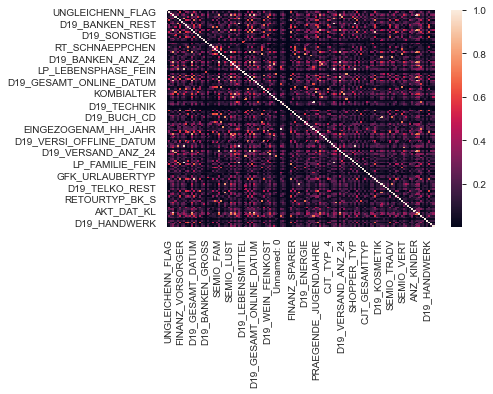

In [95]:
sns.heatmap(corr_matrix)

In [14]:
def remove_columns(df, columns_list_to_remove):
    """Returns dataframe without columns from provided list. 

    Parameters:
        df (dataframe): Original dataframe;
        df (list): column lists to exclude

    Returns:
        dataframe: without defined columns
    """  
    return df[[col for col in df.columns if col not in columns_list_to_remove]]

In [193]:
def impute_missing_data(df):
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
    imputer = imputer.fit(df)
    return imputer.transform(df)

Final data preparation function

In [219]:
def prepare_data (df1, df2, missing_percent, cor_threshold):
    """Returns prepared dataframe

    Parameters:
        df1 (dataframe): Original dataframe;
        df2 (dataframe): Other dataframe;
        missing_percent (double): maximum value to exclude columns with missing data;
        cor_threshold (double): maximum value to eclude columns with high correlations

    Returns:
        dataframe: cleaned dataframe
    """         
    common_cols = list(set(df1.columns) & set(df2.columns))
    
    df1_new = replace_values(df1[common_cols])
    print("replace unknown column values")
    
    df1_missing_columns = exclude_columns_with_many_missing_data(df1, missing_percent)
    df2_missing_columns = exclude_columns_with_many_missing_data(df2, missing_percent)
    print("removed column with missing data with more than {0} percent".format(missing_percent))
    
    columns_to_exclude = df1_missing_columns + list(set(df2_missing_columns) - set(df1_missing_columns))
    print("collect missing columns names")
    
    columns_to_keep = set(df1.columns) - set(columns_to_exclude) - set(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'])
    print("keep relevant columns")
    
    df1_new = df1_new[columns_to_keep]
    
    df1_cols = calculate_correlations(df1_new, cor_threshold)
    res = remove_columns(df1_new, df1_cols)
    
    return res

In [220]:
customers_upd_df = prepare_data(customers, azdias, 0.25, 0.8)

replace unknown column values
removed column with missing data with more than 0.25 percent
collect missing columns names
keep relevant columns


In [221]:
customers_upd_df.shape

(191652, 101)

In [222]:
azdias_upd_df = prepare_data(azdias, customers, 0.25, 0.8)

replace unknown column values
removed column with missing data with more than 0.25 percent
collect missing columns names
keep relevant columns


In [223]:
azdias_upd_df.shape

(891221, 105)

In [96]:
len(list(set(customers.columns) & set(azdias.columns)))

367

In [231]:
(azdias_upd_df.isnull().sum()/len(azdias_upd_df)*100).sort_values(ascending = False)

VK_DISTANZ           8.518314
KONSUMNAEHE          8.299737
ANZ_KINDER           8.247000
ANZ_TITEL            8.247000
ANZ_PERSONEN         8.247000
                       ...   
FINANZTYP            0.000000
D19_VOLLSORTIMENT    0.000000
D19_KOSMETIK         0.000000
D19_BANKEN_GROSS     0.000000
FINANZ_MINIMALIST    0.000000
Length: 105, dtype: float64

In [229]:
def plot_missing_values_share(df, limit):
    """Returns barplot with missing data columns, ordered descending by the biggest missing values count

    Parameters:
        df (dataframe): Original dataframe;
        limit (integer): selected value to show in the bar chart;

    Returns:
        visualization
    """         
    df_calc = ((df.isnull().sum()/len(df)*100).sort_values(ascending = False)).head(limit)
    sns.barplot(df_calc.index, df_calc.values, palette = "muted").set_title('column names with missing values')


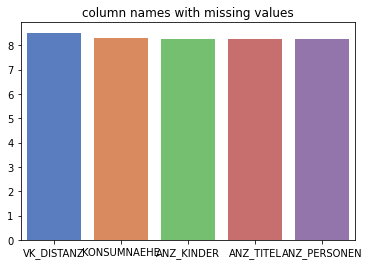

In [230]:
plot_missing_values_share(azdias_upd_df, 5)

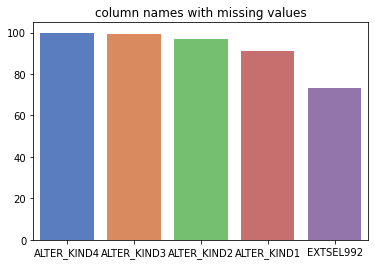

In [232]:
plot_missing_values_share(azdias, 5)

Because there are many columns, it is important to reduce the dimension. For this I selected PCA

In [233]:
scaler = StandardScaler()

In [234]:
def scale_df(df):
    df_scaled = scaler.fit(df).transform(df)
    return df_scaled

In [235]:
customers_scaled = scale_df(impute_missing_data(customers_upd_df))
azdias_scaled = scale_df(impute_missing_data(azdias_upd_df))

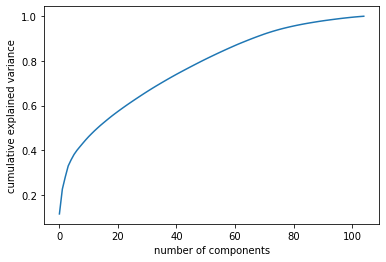

In [236]:
pca = PCA().fit(azdias_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [237]:
np.cumsum(pca.explained_variance_ratio_)

array([0.11469766, 0.22564331, 0.28011067, 0.32945247, 0.35700864,
       0.38101522, 0.39968005, 0.41565999, 0.43128026, 0.44656695,
       0.46093371, 0.47422198, 0.487037  , 0.49912606, 0.5109101 ,
       0.52198791, 0.53283016, 0.54360851, 0.55404149, 0.56400473,
       0.57374725, 0.58327249, 0.5926678 , 0.60193129, 0.61094971,
       0.61983858, 0.62864876, 0.63733512, 0.64596284, 0.65452494,
       0.66288078, 0.67114156, 0.67925341, 0.68720278, 0.69497305,
       0.70271301, 0.71035523, 0.71790676, 0.72539076, 0.73271637,
       0.73998424, 0.74707732, 0.75406283, 0.76099924, 0.76790548,
       0.77477247, 0.78157898, 0.78832163, 0.79500826, 0.80164936,
       0.80810665, 0.81451333, 0.82080627, 0.82708362, 0.83331276,
       0.83938167, 0.84541946, 0.85142566, 0.85731182, 0.86312503,
       0.86892251, 0.87459216, 0.87999847, 0.88529348, 0.89056578,
       0.89576104, 0.90087338, 0.90585972, 0.91070418, 0.91546389,
       0.92018584, 0.92460059, 0.92875245, 0.93283427, 0.93666

In [246]:
pca = PCA(n_components = 50) 
pca_tf = pca.fit_transform(azdias_scaled) 

C:\Users\Ieva\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """


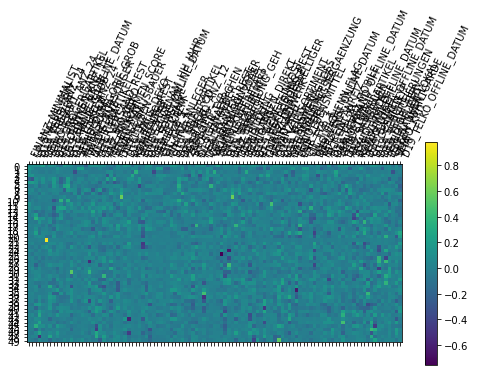

In [247]:
plt.matshow(pca.components_,cmap='viridis')
plt.yticks(np.arange(0, 50, 1.0),fontsize=10)
plt.colorbar()
plt.xticks(range(len(azdias_upd_df.columns)),azdias_upd_df.columns,rotation=65,ha='left')
plt.tight_layout()
plt.show()

In [248]:
pca_tf

array([[-4.71087169,  1.07813955, -1.97124912, ...,  0.04460408,
        -0.06659069, -0.26704521],
       [-1.7414225 , -5.84985988, -0.8675669 , ..., -0.27320192,
         0.0062472 , -0.28074059],
       [-0.36863848, -1.3965689 , -2.3408569 , ...,  1.3683335 ,
        -0.9396094 ,  0.23626652],
       ...,
       [ 3.18333779, -4.58556425, -1.63740105, ..., -0.115426  ,
        -0.66834357,  1.90139235],
       [-0.36294308, -4.2906498 ,  3.67989291, ...,  0.30648674,
         1.67895371, -0.05712979],
       [-3.45737157,  2.74921668,  3.66700874, ..., -0.16111087,
        -0.21706377,  0.32163272]])

In [249]:
km = KMeans(
    n_clusters = 3, init='random',
    n_init = 10, max_iter = 100, 
    tol=1e-04, random_state=0
)


In [251]:
y_km = km.fit_predict(pca_tf)

In [252]:
y_km

array([0, 0, 0, ..., 1, 0, 2])

In [256]:
from yellowbrick.cluster import KElbowVisualizer

C:\Users\Ieva\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [260]:
model = KMeans()
visualizer = KElbowVisualizer(
    model, k = (3,4), metric = 'calinski_harabasz', timings=False
)

In [261]:
visualizer.fit(pca_tf)  

ValueError: x and y arrays must have at least 2 entries

In [ ]:
visualizer.show()

In [82]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl


In [ ]:
# Use the quick method and immediately show the figure
kelbow_visualizer(KMeans(random_state = 0), pca_tf, k = (3, 12))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

#### References:
https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/